This notebook replicates some results from the Brunel article (Dynamics of Sparsely Connected Networks of Excitatory and Inhibitory Spiking Neurons). I use the model from the Neural Dynamics exercise (https://neuronaldynamics-exercises.readthedocs.io/en/latest/exercises/brunel-network.html) because it has really good plots. However, here, I created my own networks based on the Brian2 package at the end.

I show here all activity: fast and slow synchronous irregular state, asynchronous irregular state and synchronous regular state. For all, I calculated CV, power spectrum and theoretical and experimental stationary firing rate where it's acceptable, and leave some comments. 

It's my training experiments and they are not exhaustive.

In [1]:
import numpy as np
from scipy import integrate, special
from mpmath import mp

import matplotlib.pyplot as plt

%matplotlib inline
from neurodynex3.brunel_model import LIF_spiking_network
from neurodynex3.tools import plot_tools, spike_tools
import brian2 as b2

import random

In [2]:
# Time
min_t=0*b2.ms
max_t=500*b2.ms
dt = 0.1*b2.ms # discretization time for discrete fourier transformation

# Neuron parameters
tau = 20*b2.ms # membrane constant (ms)
thr = 20*b2.mV # threshold (mV)
V_r = 10*b2.mV # reset potentail (mV)
tau_rp = 2*b2.ms # refractory period (ms)

# Synapse parameters
D = 1.5*b2.ms # transmission delay (ms)
J = 0.1*b2.mV # synaptic strenght (mV)
g = 3.8 # This parameter further will be change
J_e = J # excitatory synaptic strenght (mV)
J_i = -J*g # inhibitory synaptic strenght (mV)


# Population
Ce = 10000 # The number of excitatory neurons
gamma = 1/4 # Excitatory/inhibitory ratio 
Ci = int(Ce*gamma) # The number of inhibitory neurons
e = 0.1 # connection probability

# Extertnal input
n = 2 # This parameter further will be changed 
C_ext = 1000 # The number of external connections
v_ext = thr/J/C_ext/tau * n # External input frequency

In [3]:
# Function for intergral for calculating the stationary firing rate
def self_consistent_eq(x):     
    return mp.exp(x**2)*(1 + mp.erf(x))

# Function for calculating the stationary firing rate
# It does it iteratevely based on coupled equations
def calc_stat_firing_rate(v, C_ext, J, v_ext, g, gamma, tau, tau_rp, V_r, thr, n=0, verbose=False, eps=0.001):
    if n == 500: return v
    
    mean = C_ext*J*tau*(v_ext + v * (1 - g * gamma))
    var = (C_ext*(J**2)*tau*(v_ext + v * (1 + g**2 * gamma)))**(1/2)
    
    a = (V_r - mean)/var
    b = (thr - mean)/var
    
    mp.dbs = 200
    # integral = integrate.dblquad(self_consistent_eq, a, b, -np.inf, lambda i: i)
    integral, error = mp.quad(self_consistent_eq, [a, b], error=True)
    integral = float(integral)

    temp = tau_rp + np.sqrt(np.pi) * tau * integral
    
    new_v = 1 / temp
    
    diff = np.abs(new_v - v)/(new_v)

    
    if diff < eps: return new_v
    
    v = v + 0.1*(new_v - v)
    n+=1

    
    if verbose == True:
        print(f"---- Itearation {n} ----")
        print(f"Integral: {integral} on [{a}, {b}] with absolute error {error}")
        print(f"Obtained v: {new_v} with relative difference {diff}")
        print(f"v: {v} with relative difference {diff}")
        
    return calc_stat_firing_rate(v, C_ext, J, v_ext, g, gamma, tau, tau_rp, V_r, thr, n, verbose, eps)

# Remove spikes which doesn't lay between t_min and t_max
def filter_spikes(spike_monitor, min_t=0*b2.ms, max_t=np.inf):
    filtered_spikes = [[np.array(y) for y in x if (y >= min_t) & (y <= max_t)]  \
                       for _, x in spike_monitor.spike_trains().items()]
    return filtered_spikes

# Function for ISI calculation
def calc_isi(spikes):
    isi_per_nr = [np.diff(x) for x in spikes]
    
    all_isi = np.hstack(isi_per_nr)
    return all_isi

# Simple function for rough firing rate estimation
def calc_mean_fr_rate(spikes, max_t, min_t=0*b2.ms):
    return np.mean([len(x) for x in spikes])/(max_t - min_t)

# Power spectrum calculation from spiking information from rate_monitor
def get_psd(rate_monitor, min_t, max_t, dt, k):
    T_sim = max_t - min_t
    T_sample = (T_sim - min_t)/k
    N = int(T_sample / dt)

    f_max = 1/2/dt
    df = 2*f_max/N


    rate = rate_monitor.rate/b2.Hz
    rate = rate[int(min_t/dt):]

    # Decreasing dimensionality by summation (suppose that m is integer)
    m = int(dt/rate_monitor.clock.dt)
    rate = rate.reshape((-1, m)).sum(-1)
    rate = rate.reshape((k, N))

    # print(rate.shape)
    fft = np.fft.fft(rate)
    psd = (np.abs(fft)**2)*dt/N/b2.ms

    # print(fft.shape)
    mean_psd = psd.mean(0)
    mean_psd = mean_psd[:int(N/2)]
    # print(mean_psd.shape)

    freqs = np.fft.fftfreq(N, dt)
    freqs = freqs[:int(N/2)]
    
    return mean_psd, freqs

# Fast irregular oscillation 

In [9]:
g = 6
J_i = -J*g # inhibitory synaptic strenght (mV)

n = 4
v_ext = thr/J/C_ext/tau * n # External input frequency

(<Figure size 720x288 with 3 Axes>,
 <Axes: title={'center': 'Raster Plot'}, ylabel='neuron #'>,
 <Axes: title={'center': 'Population Activity'}, ylabel='A(t) [Hz]'>,
 <Axes: title={'center': 'Voltage Traces'}, xlabel='t [ms]', ylabel='V(t) [mV]'>)

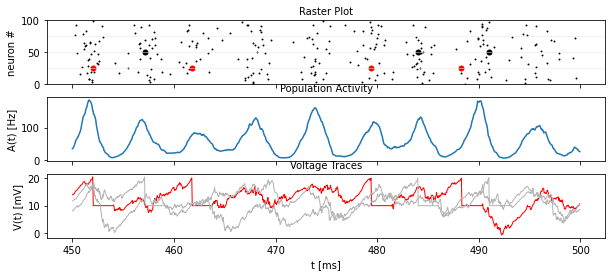

In [10]:
rate_monitor, spike_monitor, voltage_monitor, monitored_spike_idx = LIF_spiking_network.simulate_brunel_network(sim_time=max_t,
                                                                                                                N_Excit=Ce,
                                                                                                                N_Inhib=Ci,
                                                                                                                g=g, 
                                                                                                                w0=J,
                                                                                                                poisson_input_rate=v_ext, 
                                                                                                                random_vm_init=True)
plot_tools.plot_network_activity(rate_monitor, spike_monitor, voltage_monitor, spike_train_idx_list=monitored_spike_idx, t_min=max_t - 50*b2.ms)

#### The raster plot shows that there is spiking irregularity. And CV proves the point

In [11]:
spikes = filter_spikes(spike_monitor, min_t=min_t, max_t=np.inf)
all_isi = calc_isi(spikes)
CV = np.std(all_isi, ddof=1)/np.mean(all_isi)
CV

1.3893963668455662

#### Oscillation activity is discovered in the population activity plot above. Discrete Fourier transformation shows that there is a peak around 170 Hz. This oscillation is perfectly aligned with the predicted oscillation 1/4D = 166Hz frequency. Such oscillation arises so as the time duration between maximum and minimum is equal to 2 times delay. This time is needed to shift from high excitatory activity to high inhibitory activity

170. Hz


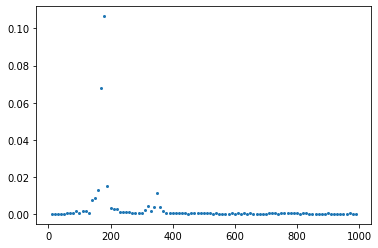

In [12]:
psd, freqs = get_psd(rate_monitor, min_t, max_t, dt, 5)
psd /= np.sum(psd)
print(freqs[np.argmax(psd[1:])])
plt.plot(freqs[1:100], psd[1:100], 'o', ms=2)

#### Brunel's article offers to calculate the stationary firing rate using self-consistent conditions. And it is agreed with the experiment here

In [18]:
# Theoretical firing rate
v = calc_stat_firing_rate(v_ext, C_ext, J, v_ext, g, gamma, tau, tau_rp, V_r, thr)
v

55.87240139 * hertz

In [19]:
# Experimental firing rate
mean_fr_rate = calc_mean_fr_rate(spikes, min_t=min_t, max_t=max_t)
mean_fr_rate

57.024 * hertz

## Slow irregular oscillation

In [4]:
g = 4.5
J_i = -J*g # inhibitory synaptic strenght (mV)

n = 0.9
v_ext = thr/J/C_ext/tau * n # External input frequency

In file included from /Users/rechique/Library/Caches/cython/brian_extensions/_cython_magic_1ba4a2cb3b90eedfa0a83d3836dfbdba.cpp:37:
In file included from /Users/rechique/opt/anaconda3/include/python3.9/Python.h:25:
/Users/rechique/opt/anaconda3/bin/../include/c++/v1/stdio.h:107:15: fatal error: 'stdio.h' file not found
#include_next <stdio.h>
              ^~~~~~~~~
1 error generated.
WARNING    Cannot use Cython, a test compilation failed: command '/Users/rechique/opt/anaconda3/bin/x86_64-apple-darwin13.4.0-clang' failed with exit code 1 (CompileError)
Certain compiler configurations (e.g. clang in a conda environment on OS X) are known to be problematic. Note that you can switch the compiler by setting the 'CC' and 'CXX' environment variables. For example, you may want to try 'CC=gcc' and 'CXX=g++'. [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slowe

(<Figure size 720x288 with 3 Axes>,
 <Axes: title={'center': 'Raster Plot'}, ylabel='neuron #'>,
 <Axes: title={'center': 'Population Activity'}, ylabel='A(t) [Hz]'>,
 <Axes: title={'center': 'Voltage Traces'}, xlabel='t [ms]', ylabel='V(t) [mV]'>)

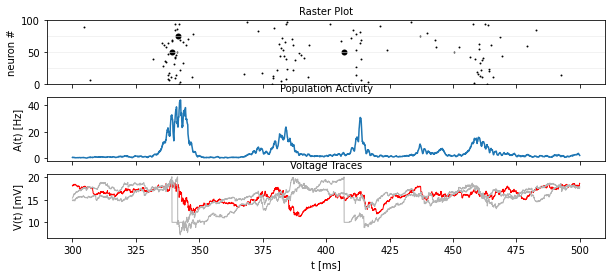

In [5]:
rate_monitor, spike_monitor, voltage_monitor, monitored_spike_idx = LIF_spiking_network.simulate_brunel_network(sim_time=max_t,
                                                                                                                N_Excit=Ce,
                                                                                                                N_Inhib=Ci,
                                                                                                                g=g, 
                                                                                                                w0=J,
                                                                                                                poisson_input_rate=v_ext, 
                                                                                                                random_vm_init=True)
plot_tools.plot_network_activity(rate_monitor, spike_monitor, voltage_monitor, spike_train_idx_list=monitored_spike_idx, t_min=max_t - 200*b2.ms)

#### Like in the fast, irregular synchronous case, there is irregularity. Raster plot supports this. CV is bigger than 1 because of the slow oscillation

In [6]:
spikes = filter_spikes(spike_monitor, min_t=min_t, max_t=np.inf)
all_isi = calc_isi(spikes)
CV = np.std(all_isi, ddof=1)/np.mean(all_isi)
CV

0.6167296590670276

#### Population activity and power spectral show synchronicity around 10Hz frequency in neurons activity

10. Hz


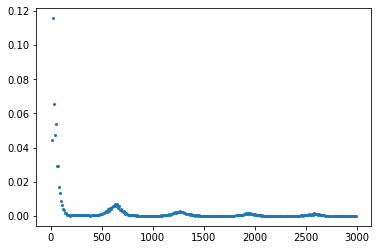

In [8]:
psd, freqs = get_psd(rate_monitor, min_t, max_t, dt, 5)
psd /= np.sum(psd)
print(freqs[np.argmax(psd[1:])])
plt.plot(freqs[1:300], psd[1:300], 'o', ms=2)

#### The theoretical firing rate is close to the experimental one

In [45]:
# Theoretical firing rate
v = calc_stat_firing_rate(v_ext, C_ext, J, v_ext, g, gamma, tau, tau_rp, V_r, thr)
v

6.516674 * hertz

In [46]:
# Experimental firing rate
mean_fr_rate = calc_mean_fr_rate(spikes, min_t=min_t, max_t=max_t)
mean_fr_rate

5.55904 * hertz

# Asynchronous irregular state

In [13]:
g = 5
J_i = -J*g # inhibitory synaptic strenght (mV)

n = 2
v_ext = thr/J/C_ext/tau * n # External input frequency

(<Figure size 720x288 with 3 Axes>,
 <Axes: title={'center': 'Raster Plot'}, ylabel='neuron #'>,
 <Axes: title={'center': 'Population Activity'}, ylabel='A(t) [Hz]'>,
 <Axes: title={'center': 'Voltage Traces'}, xlabel='t [ms]', ylabel='V(t) [mV]'>)

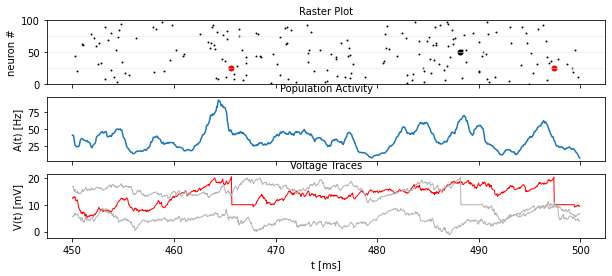

In [14]:
rate_monitor, spike_monitor, voltage_monitor, monitored_spike_idx = LIF_spiking_network.simulate_brunel_network(sim_time=max_t,
                                                                                                                N_Excit=Ce,
                                                                                                                N_Inhib=Ci,
                                                                                                                g=g, 
                                                                                                                w0=J,
                                                                                                                poisson_input_rate=v_ext, 
                                                                                                                random_vm_init=True)
plot_tools.plot_network_activity(rate_monitor, spike_monitor, voltage_monitor, spike_train_idx_list=monitored_spike_idx, t_min=max_t - 50*b2.ms)

#### There is not pronounced global oscillation in the population activity plot. Power spectral distributed along all frequencies despite the 90Hz peak frequency

100. Hz


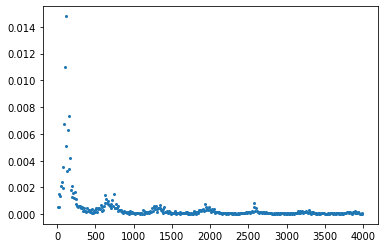

In [15]:
psd, freqs = get_psd(rate_monitor, min_t, max_t, dt, 5)
print(freqs[np.argmax(psd[1:])])
psd /= np.sum(psd)
plt.plot(freqs[1:400], psd[1:400], 'o', ms=2)

#### This activity is still irregular

In [67]:
spikes = filter_spikes(spike_monitor, min_t=min_t, max_t=np.inf)
all_isi = calc_isi(spikes)
CV = np.std(all_isi, ddof=1)/np.mean(all_isi)
CV

0.9233989251518085

#### The theoretical stationary rate is close to the experimental 

In [69]:
# Theoretical firing rate
v = calc_stat_firing_rate(v_ext, C_ext, J, v_ext, g, gamma, tau, tau_rp, V_r, thr)
v

37.97244129 * hertz

In [70]:
# Experimental firing rate
mean_fr_rate = calc_mean_fr_rate(spikes, min_t=min_t, max_t=max_t)
mean_fr_rate

37.89376 * hertz

# Synchnous regular state

In [16]:
g = 3
J_i = -J*g # inhibitory synaptic strenght (mV)

n = 2
v_ext = thr/J/C_ext/tau * n # External input frequency

(<Figure size 720x288 with 3 Axes>,
 <Axes: title={'center': 'Raster Plot'}, ylabel='neuron #'>,
 <Axes: title={'center': 'Population Activity'}, ylabel='A(t) [Hz]'>,
 <Axes: title={'center': 'Voltage Traces'}, xlabel='t [ms]', ylabel='V(t) [mV]'>)

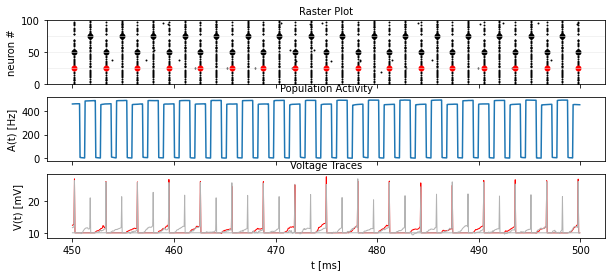

In [17]:
rate_monitor, spike_monitor, voltage_monitor, monitored_spike_idx = LIF_spiking_network.simulate_brunel_network(sim_time=max_t,
                                                                                                                N_Excit=Ce,
                                                                                                                N_Inhib=Ci,
                                                                                                                g=g, 
                                                                                                                w0=J,
                                                                                                                poisson_input_rate=v_ext, 
                                                                                                                random_vm_init=True)
plot_tools.plot_network_activity(rate_monitor, spike_monitor, voltage_monitor, spike_train_idx_list=monitored_spike_idx, t_min=max_t - 50*b2.ms)

#### Here, we see the high regular activity and oscillation on the raster plot. CV is close to 0

In [18]:
spikes = filter_spikes(spike_monitor, min_t=min_t, max_t=np.inf)
all_isi = calc_isi(spikes)
CV = np.std(all_isi, ddof=1)/np.mean(all_isi)
CV

0.056541514255160644

#### The theoretical derived stationary firing rate is not applicable because of high regularity

# Own implementation of Brunel's network based on Brain2 package

In [81]:
lif_eqs = '''
dv/dt = -v/tau : volt (unless refractory)
'''

In [82]:
g = 3 # 
J_e = J # excitatory synaptic strenght (mV)
J_i = -J*g # inhibitory synaptic strenght (mV)

n = 2
v_ext = n*thr/(tau*J*C_ext) #  (Hz)

In [83]:
b2.start_scope()

# which method is better to use? (remove)
E = b2.NeuronGroup(Ce, lif_eqs, threshold='v>thr', refractory=tau_rp, reset='v=V_r', method='linear')
E.v = 'rand()*thr'
I = b2.NeuronGroup(Ci, lif_eqs, threshold='v>thr', refractory=tau_rp, reset='v=V_r', method='linear')
I.v = 'rand()*thr'


Pe = b2.PoissonInput(E, 'v', C_ext, v_ext, weight=J_e)
Pi = b2.PoissonInput(I, 'v', C_ext, v_ext, weight=J_e)


See = b2.Synapses(E, E, on_pre='v_post+=J_e', delay=D)
See.connect(p=e)


Sei = b2.Synapses(E, I, on_pre='v_post+=J_e', delay=D)
Sei.connect(p=e)


Sie = b2.Synapses(I, E, on_pre='v_post+=J_i', delay=D)
Sie.connect(p=e)


Sii = b2.Synapses(I, I, on_pre='v_post+=J_i', delay=D)
Sii.connect(p=e)

WARNING    'v' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value 37.97244129 * hertz. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'v' is an internal variable of group 'neurongroup_1', but also exists in the run namespace with the value 37.97244129 * hertz. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


#### Here we see the same SR activity

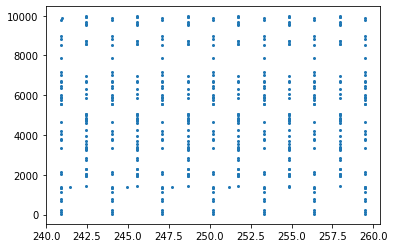

In [94]:
monitored_neurons = random.sample(range(Ce+Ci), 100)
spikemon = b2.SpikeMonitor(E, record=monitored_neurons)
# spikemon_i = SpikeMonitor(I)

b2.run(20*b2.ms)


mask = [True if x in monitored_neurons else False for x in spikemon.i]
plt.plot(spikemon.t[mask]/b2.ms, spikemon.i[mask], 'o', ms=2)